In [38]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, block_diag, identity, hstack
import matplotlib.pyplot as plt
from pyiga import assemble, bspline, vform, geometry, vis, solvers, utils, topology, algebra
from sksparse.cholmod import cholesky
from pyiga import adaptive as adap
import itertools
import time

np.set_printoptions(linewidth=100000)
np.set_printoptions(precision=5)
np.set_printoptions(formatter={'float_kind':"{:.3f}".format})

Populating the interactive namespace from numpy and matplotlib


/home/wolfman/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['hstack', 'cholesky', 'identity']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [207]:
def mp_resPois2(MP, uh, f=0., a=1., M=(0.,0.), divM = 0., neu_data={}, **kwargs):
    if isinstance(a,(int,float)):
        a={d:a for d in MP.mesh.domains}
    if isinstance(f,(int,float)):
        f={d:f for d in MP.mesh.domains}
    if isinstance(divM,(int,float)):
        divM={d:divM for d in MP.mesh.domains}
    if isinstance(M, tuple):
        M = {d:M for d in MP.mesh.domains}
        
    n = MP.mesh.numpatches
    indicator = np.zeros(MP.Z_ofs[-1])
    uh_loc = MP.Basis@uh
    uh_per_patch = dict()
    
    #residual contribution, TODO vectorize
    t=time.time()
    for p, ((kvs, geo), _) in enumerate(MP.mesh.patches):
        h = np.linalg.norm([(b-a)*kv.meshsize_max()/(kv.support()[1]-kv.support()[0]) for (a,b),kv in zip(geo.bounding_box(),kvs)])
        uh_per_patch[p] = uh_loc[np.arange(MP.N[p]) + MP.N_ofs[p]]   #cache Spline Function on patch p
        kvs0 = tuple([bspline.KnotVector(kv.mesh, 0) for kv in kvs])
        u_func = geometry.BSplineFunc(kvs, uh_per_patch[p])
        d=MP.mesh.patch_domains[p]
        
        R=h**2*assemble.assemble('(f + div(a*grad(uh)) + divM)**2 * v * dx', kvs0, geo=geo, divM=divM[d], a=a[d], f=f[d], uh=u_func,**kwargs)
        indicator[MP.Z_ofs[p]:MP.Z_ofs[p+1]] = R.ravel()
    print('residual contributions took ' + str(time.time()-t) + ' seconds.')
    
    #flux contribution
    t=time.time()
    for i,((p1,b1,_), (p2,b2,_), flip) in enumerate(MP.intfs):
        ((kvs1, geo1), _), ((kvs2, geo2), _) = MP.mesh.patches[p1], MP.mesh.patches[p2]
        bdspec1, bdspec2 = [assemble.int_to_bdspec(b1)], [assemble.int_to_bdspec(b2)]
        bkv1, bkv2 = assemble.boundary_kv(kvs1, bdspec1), assemble.boundary_kv(kvs2, bdspec2)
        geo = geo2.boundary(bdspec2)
        kvs02 = tuple([bspline.KnotVector(kv.mesh, 0) for kv in kvs2])
        kvs01 = tuple([bspline.KnotVector(kv.mesh, 0) for kv in kvs1])
        bkv02 = assemble.boundary_kv(kvs02,bdspec=bdspec2)
        bkv01 = assemble.boundary_kv(kvs01,bdspec=bdspec1)
        h = np.sum(assemble.assemble('v * ds', bkv02, geo=geo))*bkv02[0].meshsize_max()/(bkv02[0].support()[1]-bkv02[0].support()[0])
        uh1_grad = geometry.BSplineFunc(kvs1, uh_per_patch[p1]).transformed_jacobian(geo1).boundary(bdspec1, flip=flip) #physical gradient of uh on patch 1 (flipped if needed)
        uh2_grad = geometry.BSplineFunc(kvs2, uh_per_patch[p2]).transformed_jacobian(geo2).boundary(bdspec2)            #physical gradient of uh on patch 2
        d1, d2 = MP.mesh.patch_domains[p1], MP.mesh.patch_domains[p2]
        J = assemble.assemble('((inner((a1 * uh1_grad + M1) - (a2 * uh2_grad + M2), n) )**2 * v ) * ds', bkv02 ,geo=geo,a1=a[d1],a2=a[d2],uh1_grad=uh1_grad,uh2_grad=uh2_grad,M1=M[d1],M2=M[d2],**kwargs)

        indicator[MP.Z_ofs[p2]+assemble.boundary_dofs(kvs02, bdspec=bdspec2, ravel=1)] += 0.5 * h * J
        indicator[MP.Z_ofs[p1]+assemble.boundary_dofs(kvs01, bdspec=bdspec1, ravel=1)] += 0.5 * h * bspline.prolongation(bkv01[0],bkv02[0]).T@J
        
    for bd in neu_data:
        g = neu_data[bd]
        for (p,b) in MP.mesh.outer_boundaries[bd]:
            ((kvs, geo), _) = MP.mesh.patches[p]
            kvs0 = tuple([bspline.KnotVector(kv.mesh, 0) for kv in kvs0])
            bdspec = [assemble.int_to_bdspec(b)]
            bkv0 = assemble.boundary_kv(kvs0, bdspec)
            geo_b = geo.boundary(bdspec)
            d=MP.mesh.patch_domains[p]
            uh_grad = geometry.BSplineFunc(kvs, uh_per_patch[p]).transformed_jacobian(geo).boundary(bdspec)
            J = np.sum(assemble.assemble('(inner(a * uh_grad, n) - g)**2 * v * ds', bkv0 ,geo=geo_b, a=a[d], uh_grad=uh_grad, **kwargs))
            indicator[MP.Z_ofs[p1]+assemble.boundary_dofs(kvs0,bdspec=bdspec, ravel=1)] += h * J
    print('jump contributions took ' + str(time.time()-t) + ' seconds.')
    return np.sqrt(indicator)

In [201]:
kvs=5*[2*(bspline.make_knots(5,0.0,1.0,10),)]
geos=geometry.mp_disk()
M = topology.PatchMesh(list(zip(kvs,geos)))
M.set_domain_id({0:{0},1:{1},2:{2},3:{3},4:{4}})
MP = assemble.Multipatch(M, automatch=True)


Basis setup took 0.0048334598541259766 seconds


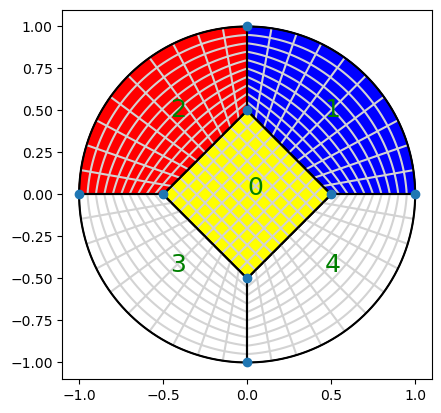

In [202]:
M.draw(knots=1, nodes=1, color={0:'yellow',1:'blue',2:'red'}, patch_idx=1)

In [203]:
def u(x,y):
    idx = (abs(x) + abs(y) > 0.5)
    vals = abs(x)+abs(y)
    vals[idx] = 0.
    return vals
u_ = MP.L2projection(u= lambda x,y: u(x,y))

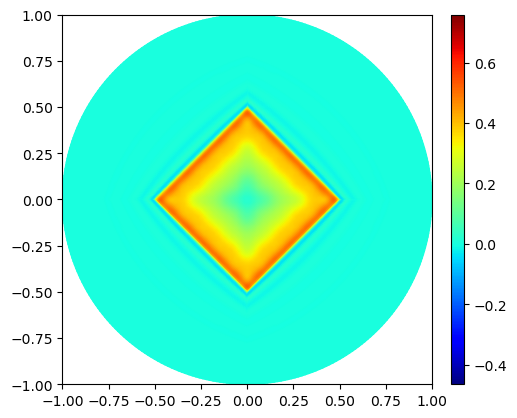

In [205]:
MP.plot(u_)

In [206]:
u_

array([0.241, 0.410, 0.240, ..., 0.005, -0.002, 0.001])

In [192]:
mp_resPois2(MP, u_, f=-4.)

residual contributions took 0.05300545692443848 seconds.
2 3 [0.607 0.007 0.000]
1 2 [0.607 0.007 0.000]
0 3 [3.834 0.906 3.834]
0 4 [3.834 0.906 3.834]
0 1 [3.834 0.906 3.834]
0 2 [3.834 0.906 3.834]
1 4 [0.607 0.007 0.000]
3 4 [0.607 0.007 0.000]


array([2.180, 2.128, 2.180, 2.128, 4.755, 2.128, 2.180, 2.128, 2.180, 3.198, 1.286, 0.067, 2.048, 1.082, 0.315, 3.198, 1.286, 0.067, 3.198, 1.286, 0.067, 2.048, 1.082, 0.315, 3.198, 1.286, 0.067, 3.198, 1.286, 0.067, 2.048, 1.082, 0.315, 3.198, 1.286, 0.067, 3.198, 1.286, 0.067, 2.048, 1.082, 0.315, 3.198, 1.286, 0.067])

In [156]:
np.append

<function numpy.append(arr, values, axis=None)>

In [124]:
kvy = [8,4,8,5,2,4]
kvx = [2,4,3,6,5,8]

kvs=[(bspline.make_knots(1,0.0,1.0,xN),bspline.make_knots(1,0.0,1.0,yN)) for xN,yN in zip(kvx,kvy)]
geos=[geometry.unit_square(support=((0.,1.),(0.0,0.5))).scale((2,1)),
      geometry.unit_square(support=((0.,1.),(0.5,1.))).scale((2,1)),
      geometry.Quad(np.array([[0.,2.,1.,2.],
                              [1.,1.,2.,2.]])),
      geometry.Quad(np.array([[2.,3.,2.,3.5],
                              [1.,1.,2.,2.5]])),
      geometry.Quad(np.array([[2.,3.,3.,3.5],
                              [1.,0.,1.,0.5]])),
      geometry.Quad(np.array([[2.,2.5,2.,3.],
                              [0.,-0.5,1.,0.]])),]

patches = [(tuple(bspline.mapto(k[d],lambda x: g.support[d][1]*x + g.support[d][0]*(1-x)) for d in range(2)), g) for k, g in zip(kvs,geos)]
M=topology.PatchMesh(patches)
M.sanity_check()
#M.h_refine(patches={5:-1, 2:-1});

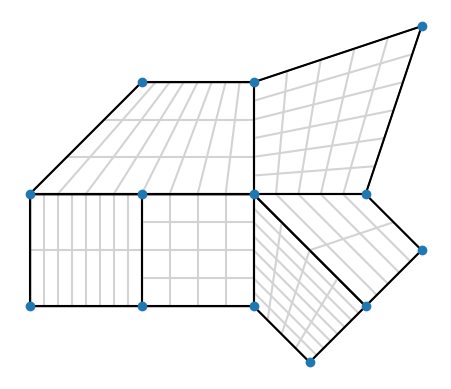

In [18]:
M.draw(knots=1, patch_idx=0, nodes=1, axis='off')
axis('scaled');

In [2]:
def drawSkeleton(MP):
    for (p,b,_),(_,_,_),_ in MP.intfs:
        ax,sd=assemble.int_to_bdspec(b)
        geo=MP.mesh.geos()[p]
        kvs=MP.mesh.kvs()[p]
        grid=np.linspace(geo.support[(ax+1)%2][0], geo.support[(ax+1)%2][1],kvs[(ax+1)%2].numdofs)
        if (p,b) == (4,1) or (p,b)==(5,3): grid=grid[1:-1]
        if ax==0:
            Z = geo.eval(grid,np.array([geo.support[0][sd]]))
        else:
            Z = geo.eval(np.array([geo.support[1][sd]]),grid)
        plt.scatter(Z[:,:,0].ravel(),Z[:,:,1].ravel(),color='red',s=15,zorder=3)
    
def drawInterior(MP,r=1):
    for p in range(MP.numpatches):
        kvs, geo = MP.mesh.kvs()[p], MP.mesh.geos()[p]
        gridx=np.linspace(geo.support[0][0],geo.support[0][1] ,kvs[0].numdofs)
        gridy=np.linspace(geo.support[1][0],geo.support[1][1],kvs[1].numdofs)
        Z = geo.eval(gridx,gridy)
        if r != 0:
            plt.scatter(Z[r:-r,r:-r,0].ravel(),Z[r:-r,r:-r,1].ravel(),color='black',s=15)
        else:
            for idx in MP.mesh.outer_boundaries:
                if (p,2) not in MP.mesh.outer_boundaries[idx]: Z = Z[1:,:,:]
                if (p,3) not in MP.mesh.outer_boundaries[idx]: Z = Z[:-1,:,:]
                if (p,0) not in MP.mesh.outer_boundaries[idx]: Z = Z[:,1:,:]
                if (p,1) not in MP.mesh.outer_boundaries[idx]: Z = Z[:,:-1,:]
            plt.scatter(Z[:,:,0].ravel(),Z[:,:,1].ravel(),color='black',s=15,zorder=2)

In [43]:
kv1=bspline.KnotVector(np.array([0.0,0.3,0.6,1.0]),0)
kv2=bspline.KnotVector(np.array([0.0,0.2,0.4,0.6,0.8,1.0]),0)

In [44]:
B=bspline.prolongation(kv1,kv2)

In [45]:
B.A.T

array([[1.000, 0.000, 0.000, 0.000, 0.000],
       [0.000, 1.000, 1.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, 1.000, 1.000]])

In [46]:
kvs=(kv1,kv2)

In [47]:
bspline.numspans(kvs)

15

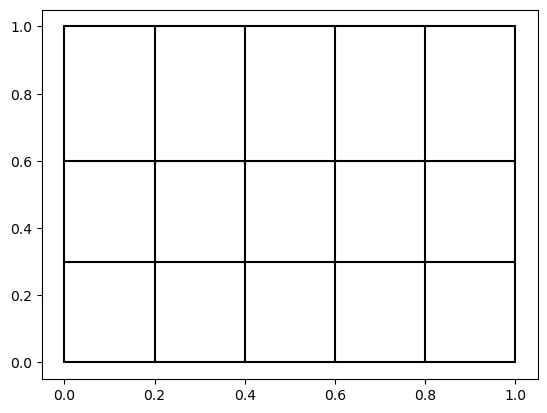

In [59]:
vis.plot_geo(geometry.unit_square(), gridx=kvs[1].mesh, gridy=kvs[0].mesh)

In [61]:
assemble.boundary_dofs(kvs, bdspec=[(0,1)], ravel=1)

array([10, 11, 12, 13, 14])

In [74]:
a={0:1}
b={0:2,3:4}

In [76]:
set(b) - set(a)

{3}

In [77]:
type('a')

str